# Momentum Strategy - Weekly Rebalance


1. Rank Stocks in SP500 based on momentum. Momentum: calculated by multiplying the annualized exponential regression slope of past 90 days by R^2 coeeffecient of regression calc
2. Position Size: Calc using 20 day ATR of each stock, multiplied by 10 basis points of portfolio value
3. Open new positions only if SP 500 is above 200 day moving avg
4. Every week, sell stocks that are not in top 20% momentum ranking, or have fallen below their 100 day moving avg. Buy stocks in top 20% momentum rankings
5. Every other week, rebalance exisitng positions with updated ATR values
https://teddykoker.com/2019/05/momentum-strategy-from-stocks-on-the-move-in-python/


Alpaca / Synthetic long short :
https://www.theoptionsguide.com/synthetic-short-stock.aspx
https://www.theoptionsguide.com/synthetic-long-stock.aspx?source=post_page-----25d580ccab0c----------------------
https://www.investopedia.com/articles/optioninvestor/08/synthetic-options.asp

https://medium.com/automation-generation/ultimate-list-of-automated-trading-strategies-you-should-know-part-3-25d580ccab0c

DATA: 
* AlphaVantage: https://www.alphavantage.co/documentation/6a772cd25
* QUANDL
* Or just learn Quant Connect
* Look into Kelly Edge

In [1]:
import requests
import pandas as pd
import os
import bs4 as bs
import numpy as np
from scipy.stats import linregress

In [2]:
def get_sp500():
    url = "http://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    resp = requests.get(url)
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text.strip()
        tickers.append(ticker)  
    #with open("sp500tickers.pickle","wb") as f:
    #    pickle.dump(tickers,f)  
    return tickers

In [3]:
def generate_massive_df(tickers):
    stocks = (
        (pd.concat(
            [pd.read_csv(f"data/{ticker}.csv", index_col='Date', parse_dates=True)[
                'Close'
            ].rename(ticker)
            for ticker in tickers if os.path.exists("data/{}.csv".format(ticker))],
            axis=1,
            sort=True)
        )
    )
    stocks = stocks.loc[:,~stocks.columns.duplicated()]
    return stocks

In [4]:
def momentum(closes):
    returns = np.log(closes)
    x = np.arange(len(returns))
    slope, _, rvalue, _, _ = linregress(x,returns)
    return ((1 + slope) ** 252 * (rvalue ** 2))

In [5]:
def apply_momentum(stocks, tickers):
    momentums = stocks.copy(deep=True)
    for ticker in tickers:
        if os.path.exists("data/{}.csv".format(ticker)):
            momentums[ticker] = stocks[ticker].rolling(90).apply(momentum, raw=False)
    return momentums

In [6]:
tickers = get_sp500()
stocks = generate_massive_df(tickers)

In [7]:
stocks

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,235.639999,58.790001,98.410004,192.490005,153.839996,64.309998,177.699997,10.980000,106.089996,10.880000,...,146.990005,164.300003,47.810001,29.370001,67.879997,68.070000,81.599998,124.059998,50.700001,71.769997
2018-01-03,235.630005,58.919998,99.949997,195.820007,154.550003,65.309998,181.039993,11.550000,107.050003,10.870000,...,149.740005,162.520004,47.490002,29.330000,69.239998,68.900002,81.529999,124.919998,50.639999,72.099998
2018-01-04,238.710007,58.820000,99.379997,199.250000,156.380005,64.660004,183.220001,12.120000,111.000000,10.830000,...,151.259995,163.399994,47.119999,29.690001,70.489998,69.360001,82.360001,124.739998,50.849998,72.529999
2018-01-05,240.570007,58.990002,101.110001,202.320007,157.669998,66.370003,185.339996,11.880000,112.180000,10.870000,...,152.229996,164.490005,46.790001,29.910000,74.150002,69.230003,82.839996,125.980003,50.869999,73.360001
2018-01-08,239.789993,58.820000,99.489998,207.800003,158.929993,66.629997,185.039993,12.280000,111.389999,10.870000,...,151.410004,162.300003,47.139999,30.260000,74.639999,69.480003,82.980003,126.220001,50.619999,74.239998
2018-01-09,241.279999,58.919998,100.239998,209.759995,159.460007,66.190002,186.699997,11.820000,110.489998,10.760000,...,151.830002,163.399994,46.590000,30.190001,74.839996,69.500000,82.760002,124.190002,51.810001,75.110001
2018-01-10,241.139999,58.830002,99.690002,208.139999,158.899994,66.830002,187.110001,11.960000,110.589996,10.780000,...,153.610001,162.000000,46.130001,30.350000,74.099998,69.000000,82.550003,122.529999,52.349998,73.910004
2018-01-11,242.309998,58.950001,99.269997,210.149994,159.110001,69.239998,188.919998,12.140000,112.949997,10.960000,...,154.759995,162.500000,45.520000,31.860001,74.339996,69.970001,82.489998,122.290001,53.110001,74.589996
2018-01-12,244.470001,58.840000,100.339996,215.110001,160.110001,70.360001,195.050003,12.020000,115.940002,11.040000,...,155.460007,165.539993,45.150002,32.770000,74.660004,70.459999,83.620003,122.099998,53.279999,75.389999


In [8]:
momentum = apply_momentum(stocks[-200:], tickers)

In [9]:
# Only want to calc momentum for most recent 90 days
# How tf to do dis

In [10]:
momentum

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
bests = momentum[-1:].max().sort_values(ascending=False).index[:5]
bests


Index(['WDC', 'KLAC', 'MU', 'LRCX', 'JBHT'], dtype='object')

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 

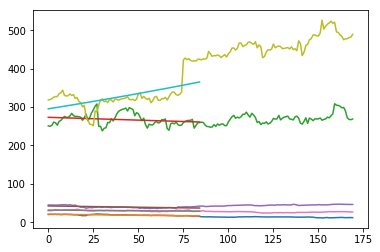

In [19]:
import matplotlib.pyplot as plt
bests = momentum.max().sort_values(ascending=False).index[:5]
for best in bests:
    end = momentum[best].index.get_loc(momentum[best].idxmax())
    rets = np.log(stocks[best].iloc[end - 85 : end])
    x = np.arange(len(rets))
    print(x)
    slope, intercept, r_value, p_value, std_err = linregress(x, rets)
    plt.plot(np.arange(170), stocks[best][end-85:end+85])
    plt.plot(x, np.e ** (intercept + slope*x))

In [16]:
bests

Index(['COTY', 'ANET', 'CDNS', 'XRX', 'CMG'], dtype='object')